* ДЗ_28 - распознавание возраста
* Капустин Я.Д.
* 05.04.2023
* v.0.1
* ДЗ - оценить возраст человека по изображению
* https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, CategoryEncoding,\
                                    Dropout, BatchNormalization, AveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf

pd.set_option('display.max_rows', 30)

In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
df = pd.DataFrame(columns=['link', 'age']) ### Создаем пустой Dataframe с колонками Link - ссылка на файл, Age - Возраст

for folder_name in tqdm(os.listdir('wiki_crop')):
    for file_name in os.listdir('wiki_crop\\'+folder_name):
        #формируем ссылку на изображение
        link = 'wiki_crop\\' + folder_name + '\\' + file_name
        
        img = cv2.imread(link)
        if img.shape[0]<96: ### Уберем совсем мелкие и неинформативные изображения
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 6) ## Выставим досточно жесткие условия.
        
        #### Если лицо обнаружено (сумма элементов массива больше 0), то добавляем строку в Dataframe
        if len(faces)>0:
            if len(faces)>1: ### Уберем изображения, на которых выявлено несколько лиц.
                continue
            #определение возраст
            name = file_name[:-4] #убираем расширение файла из имени
            age_end = name.split('_')[2] # делаем сплит по нижнему подчеркиванию и выбираем последнюю дату
            age_start=str(name.split('_')[1]).split('-')[0] # делаем сплит, выбираем первую дату и далаем сплит по дефису, 
                                                            # выбираем год.
            age_fin = int(age_end)-int(age_start) #Вычисляем возраст
            
            if age_fin>100 or age_fin<0: # Если возраст больше 100 или меньше 0, то выкидываем из набора
                continue
            
            #формируем временный датафрейм
            data = pd.DataFrame({"link": [link],
                                 "age": [age_fin]})
            #Делаем конкатенацию с основным датафреймом.
            df = pd.concat([df,data])

df.to_csv('data_cleaned.csv') #Сохраним в файл полученный Dataframe на случай перезагрузки, чтобы не чистить второй раз )))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:05<00:00,  4.86s/it]


In [4]:
df = pd.read_csv('data_cleaned.csv')

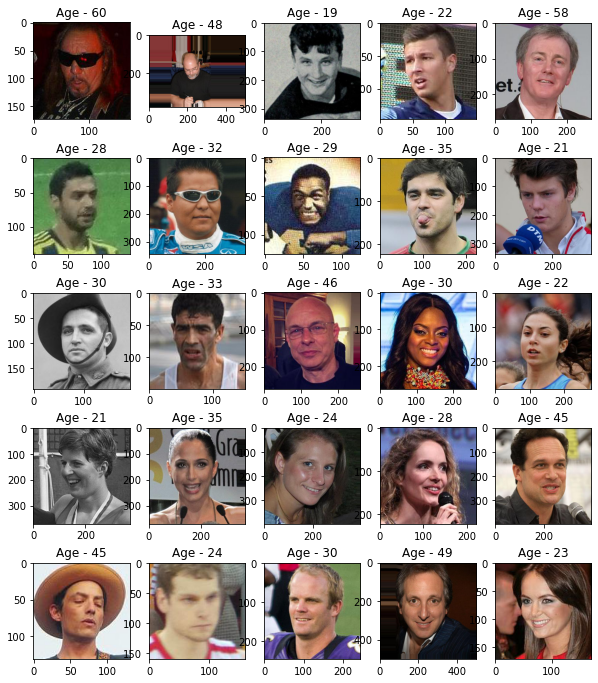

In [5]:
idx = np.random.randint (0,len(df),25)
plt.figure(figsize=(10,12))
for idx in enumerate(idx):
    plt.subplot (5,5,idx[0]+1)
    link = df.iloc[idx[1]]
    image = plt.imread(link[1])
    title = 'Age - ' + str(link[2])
    plt.title (title)
    plt.imshow(image, cmap='gray');

In [6]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [8]:
TARGET_SIZE = (224,224)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="link",
y_col="age",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

Found 14923 validated image filenames.
Found 6395 validated image filenames.
Found 5330 validated image filenames.


In [9]:
#### Создаем архитектуру модели
model_conv = Sequential()

model_conv.add (Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(112,112,3)))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(128, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(256, (3,3), padding='same', activation='relu'))

model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add (Conv2D(512, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add(GlobalMaxPool2D())

model_conv.add(Dense(1000, activation='relu'))

model_conv.add(Dense(1, activation='linear'))

model_conv.compile(optimizer=Adam(learning_rate=0.00005), loss='mse', metrics=['mae'])

#### Задаем колбэки
checkpoint_cb_conv = ModelCheckpoint("ConvModelFull.h5", 
                                     monitor = 'val_mae',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

#### Обучаем модель
history2 = model_conv.fit(train_generator,
                          validation_data=valid_generator,
                          callbacks=[checkpoint_cb_conv,lr_scheduler],
                          epochs=10)

Epoch 1/10
467/467 [==============================] - 74s 137ms/step - loss: 345.3907 - mae: 14.7284 - val_loss: 264.9566 - val_mae: 13.1951 - lr: 5.0000e-05
Epoch 2/10
467/467 [==============================] - 61s 130ms/step - loss: 257.2895 - mae: 12.8655 - val_loss: 256.4863 - val_mae: 12.2099 - lr: 5.0000e-05
Epoch 3/10
467/467 [==============================] - 62s 132ms/step - loss: 241.6448 - mae: 12.3098 - val_loss: 261.4807 - val_mae: 13.6105 - lr: 5.0000e-05
Epoch 4/10
467/467 [==============================] - 62s 132ms/step - loss: 233.5382 - mae: 12.0908 - val_loss: 226.2025 - val_mae: 11.8046 - lr: 5.0000e-05
Epoch 5/10
467/467 [==============================] - 62s 132ms/step - loss: 222.8365 - mae: 11.7804 - val_loss: 216.5229 - val_mae: 11.5557 - lr: 5.0000e-05
Epoch 6/10
467/467 [==============================] - 61s 131ms/step - loss: 216.2823 - mae: 11.5654 - val_loss: 211.1210 - val_mae: 11.3816 - lr: 5.0000e-05
Epoch 7/10
467/467 [==============================] 

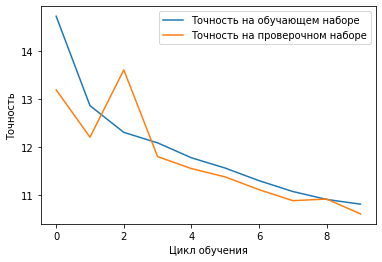

In [10]:
plt.plot(history2.history['mae'], label='Точность на обучающем наборе')
plt.plot(
    history2.history['val_mae'], label='Точность на проверочном наборе')
plt.xlabel('Цикл обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()
pass;

In [11]:
model_conv.evaluate (test_generator)

167/167 [==============================] - 12s 73ms/step - loss: 195.8759 - mae: 10.6197


[195.87588500976562, 10.619677543640137]

1/1 [==============================] - 0s 22ms/step


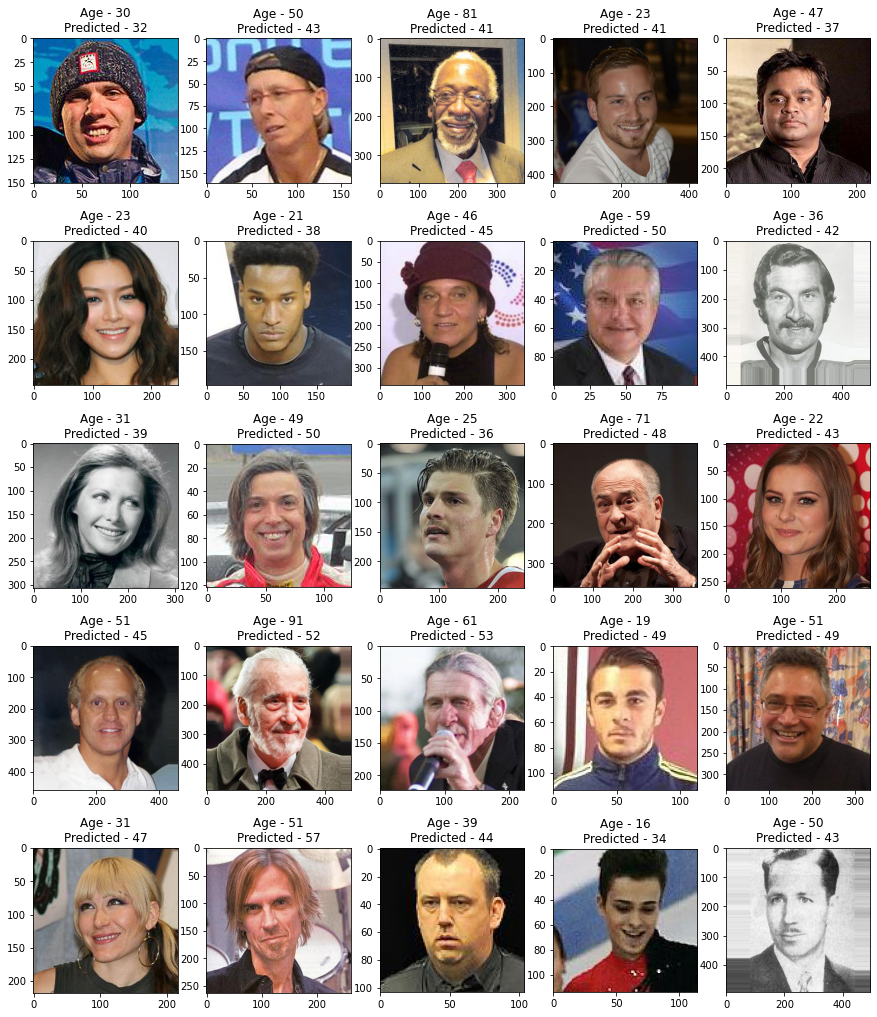

In [28]:
idx = np.random.randint (0,len(test),25)
plt.figure(figsize=(15,18))
for idx in enumerate(idx):
    plt.subplot (5,5,idx[0]+1)
    link = test.iloc[idx[1]]
    image = plt.imread(link[1])
    
    img_resized = cv2.resize (image, (112,112))/255
    img_reshaped  = img_resized.reshape (1,112,112,3)
    predict = model_conv.predict(img_reshaped)[0][0];
    
    title = 'Age - ' + str(link[2]) + '\nPredicted - ' + str(int(predict))
    plt.title (title)
    plt.imshow(image, cmap='gray');